In [2]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import gym
import gym_minigrid
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class QLearning:
    def __init__(self, actions, agent_indicator=10, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.actions = actions
        self.agent_indicator = agent_indicator
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_values = defaultdict(lambda: [0.0] * actions)
        
    def _convert_state(self, s):
        return np.where(s == self.agent_indicator)[0][0]
        
    def update(self, state, action, reward, next_state):        
        q_value = self.q_values[state][action]
        
        ########################## Write Code ####################################
        
        max_next_q = max(self.q_values[next_state])
        
        target = reward + self.gamma * max_next_q
        td_error = target - q_value

        self.q_values[state][action] = q_value + self.alpha * td_error
        ###########################################################################
        
    def act(self, state):
        #################### Write epsilion greedy code ###########################
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            # state = self._convert_state(state)
            q_values = self.q_values[state]
            action = np.argmax(q_values)
        ###########################################################################
        return action

In [4]:
class SARSA:
    def __init__(self, actions, agent_indicator=10, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.actions = actions
        self.agent_indicator = agent_indicator
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_values = defaultdict(lambda: [0.0] * actions)
        
    def _convert_state(self, s):
        return np.where(s == self.agent_indicator)[0][0]
        
    # SARSA 업데이트 규칙 구현
    def update(self, state, action, reward, next_state, next_action):
        """ SARSA 업데이트 함수
        Args:
            state: 현재 상태 (s)
            action: 선택한 행동 (a)
            reward: 받은 보상 (r)
            next_state: 다음 상태 (s')
            next_action: 다음 상태에서 선택할 행동 (a')
        """
        current_q = self.q_values[state][action]

        # 다음 상태(next_state)에서 실제로 선택될 행동(next_action)의 Q값을 사용
        next_q = self.q_values[next_state][next_action]

        # SARSA 타겟 값 계산: r + γ * Q(s', a')
        target = reward + self.gamma * next_q

        # TD 오차 계산
        td_error = target - current_q

        # Q값 업데이트: Q(s, a) <- Q(s, a) + α * TD 오차
        self.q_values[state][action] = current_q + self.alpha * td_error
        
    def act(self, state):
        #################### Write epsilion greedy code ###########################
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            # state = self._convert_state(state)
            q_values = self.q_values[state]
            action = np.argmax(q_values)
        ###########################################################################
        return action

In [5]:
from utils import gen_wrapped_env, show_video

In [ ]:
env_name = 'MiniGrid-Empty-6x6-v0'
#env_name = 'MiniGrid-DoorKey-5x5-v0'

env = gen_wrapped_env(env_name)

array([10,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,
        0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  1,
        0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  8,  1,  0],
      dtype=uint8)

In [14]:
obs = env.reset()

agent_position = obs[0]

num_actions = env.action_space.n
if env_name == 'MiniGrid-Empty-6x6-v0':
    num_actions = 4 # MiniGrid-Empty-6x6-v0 환경에서는 이동만 필요해서
    

print(f"환경: {env_name}, 행동 개수: {num_actions}")

# 에이전트 초기화
# agent_indicator 는 gen_wrapped_env 구현에 따라 불필요할 수 있음
q_agent = QLearning(actions=num_actions)
sarsa_agent = SARSA(actions=num_actions)

num_episodes = 50000  # 에피소드 수 (충분히 크게 설정)
max_steps_per_episode = 100 # 에피소드 최대 스텝 (MiniGrid 기본값 사용 가능)

환경: MiniGrid-Empty-6x6-v0, 행동 개수: 4


In [15]:
# 학습 함수 정의
def train(agent, env, num_episodes, max_steps_per_episode, algorithm_name):
    print(f"\n{algorithm_name} 학습 시작...")
    rewards_history = []
    success_history = [] # 성공 여부 기록
    q_value_history = [] # 특정 상태-행동 Q값 변화 기록 (선택적)
    # 예: 시작 상태에서의 'forward' 행동 Q값
    # initial_obs_tuple = q_agent._convert_state(env.reset()) # 상태 변환 함수 사용

    for ep in range(num_episodes):
        state = q_agent._convert_state(env.reset()) # 상태 변환
        action = agent.act(state) # 첫 행동 선택 (SARSA/Q-Learning 공통)
        done = False
        ep_rewards = 0
        step_count = 0

        # 특정 Q값 추적 (선택 사항)
        # start_state_forward_q = agent.q_values[initial_obs_tuple][2] # 행동 2가 'forward'라고 가정
        # q_value_history.append(start_state_forward_q)

        while not done and step_count < max_steps_per_episode:
            next_obs, reward, done, info = env.step(action)
            next_state = q_agent._convert_state(next_obs) # 다음 상태 변환

            ep_rewards += reward
            step_count += 1

            if algorithm_name == 'QLearning':
                agent.update(state, action, reward, next_state) # Q-Learning 업데이트
                next_action = agent.act(next_state) # 다음 스텝에 사용할 행동 선택
            elif algorithm_name == 'SARSA':
                next_action = agent.act(next_state) # SARSA: 다음 행동 먼저 선택
                agent.update(state, action, reward, next_state, next_action) # SARSA 업데이트
            else:
                 raise ValueError("Unknown algorithm name")

            state = next_state
            action = next_action

        rewards_history.append(ep_rewards)
        # 성공 기준 정의 (DoorKey: reward > 0 이면 성공)
        success = 1 if ep_rewards > 0 else 0
        success_history.append(success)

        if (ep + 1) % 1000 == 0: # 로그 출력 빈도 조절
            avg_reward = np.mean(rewards_history[-100:])
            avg_success_rate = np.mean(success_history[-100:])
            print(f"Episode: {ep+1}/{num_episodes}, Avg Reward (Last 100): {avg_reward:.3f}, Avg Success Rate (Last 100): {avg_success_rate:.3f}")

    print(f"{algorithm_name} 학습 완료.")
    env.close() # 에피소드 종료 후 환경 닫기 (선택적)
    return rewards_history, success_history, agent.q_values # 학습된 Q-테이블 반환


In [16]:
# Q-Learning 학습 실행
rewards_q, success_q, q_table_q = train(q_agent, env, num_episodes, max_steps_per_episode, 'QLearning')


QLearning 학습 시작...
Episode: 1000/50000, Avg Reward (Last 100): 0.000, Avg Success Rate (Last 100): 0.000
Episode: 2000/50000, Avg Reward (Last 100): 0.294, Avg Success Rate (Last 100): 0.510
Episode: 3000/50000, Avg Reward (Last 100): 0.325, Avg Success Rate (Last 100): 0.540
Episode: 4000/50000, Avg Reward (Last 100): 0.322, Avg Success Rate (Last 100): 0.550
Episode: 5000/50000, Avg Reward (Last 100): 0.325, Avg Success Rate (Last 100): 0.580
Episode: 6000/50000, Avg Reward (Last 100): 0.359, Avg Success Rate (Last 100): 0.590
Episode: 7000/50000, Avg Reward (Last 100): 0.281, Avg Success Rate (Last 100): 0.490
Episode: 8000/50000, Avg Reward (Last 100): 0.283, Avg Success Rate (Last 100): 0.480
Episode: 9000/50000, Avg Reward (Last 100): 0.326, Avg Success Rate (Last 100): 0.530
Episode: 10000/50000, Avg Reward (Last 100): 0.195, Avg Success Rate (Last 100): 0.340
Episode: 11000/50000, Avg Reward (Last 100): 0.213, Avg Success Rate (Last 100): 0.350
Episode: 12000/50000, Avg Reward

In [17]:
# SARSA 학습 실행
rewards_sarsa, success_sarsa, q_table_sarsa = train(sarsa_agent, env, num_episodes, max_steps_per_episode, 'SARSA')


SARSA 학습 시작...
Episode: 1000/50000, Avg Reward (Last 100): 0.000, Avg Success Rate (Last 100): 0.000
Episode: 2000/50000, Avg Reward (Last 100): 0.000, Avg Success Rate (Last 100): 0.000
Episode: 3000/50000, Avg Reward (Last 100): 0.000, Avg Success Rate (Last 100): 0.000
Episode: 4000/50000, Avg Reward (Last 100): 0.000, Avg Success Rate (Last 100): 0.000
Episode: 5000/50000, Avg Reward (Last 100): 0.289, Avg Success Rate (Last 100): 0.530
Episode: 6000/50000, Avg Reward (Last 100): 0.183, Avg Success Rate (Last 100): 0.360
Episode: 7000/50000, Avg Reward (Last 100): 0.279, Avg Success Rate (Last 100): 0.510
Episode: 8000/50000, Avg Reward (Last 100): 0.130, Avg Success Rate (Last 100): 0.240
Episode: 9000/50000, Avg Reward (Last 100): 0.271, Avg Success Rate (Last 100): 0.480
Episode: 10000/50000, Avg Reward (Last 100): 0.244, Avg Success Rate (Last 100): 0.450
Episode: 11000/50000, Avg Reward (Last 100): 0.222, Avg Success Rate (Last 100): 0.410
Episode: 12000/50000, Avg Reward (La

In [9]:
# rewards = []
# for ep in range(50000):
#     done = False
#     obs = env.reset()
#     action = agent.act(obs)
    
#     ep_rewards = 0
#     while not done:
#         next_obs, reward, done, info = env.step(action)

#         next_action = agent.act(next_obs)

#         agent.update(obs, action, reward, next_obs, next_action)
        
#         ep_rewards += reward
#         obs = next_obs
#         action = next_action
#     rewards.append(ep_rewards)
#     if (ep+1) % 20 == 0:
#         print("episode: {}, rewards: {}".format(ep+1, ep_rewards))
# env.close()

In [10]:
# {s:np.round(q, 5).tolist() for s, q in agent.q_values.items()}

In [11]:
show_video()

In [12]:
# pd.Series(rewards).to_csv('./logs/rewards_qlearning.csv')

In [13]:
# sarsa_logs = pd.read_csv('./logs/rewards_sarsa.csv', index_col=False).iloc[:, 1]
# q_logs = pd.read_csv('./logs/rewards_qlearning.csv', index_col=False).iloc[:, 1]

In [18]:
# 결과 저장
pd.Series(rewards_q).to_csv(f'./logs/rewards_qlearning_{env_name}.csv')
pd.Series(success_q).to_csv(f'./logs/success_qlearning_{env_name}.csv')
pd.Series(rewards_sarsa).to_csv(f'./logs/rewards_sarsa_{env_name}.csv')
pd.Series(success_sarsa).to_csv(f'./logs/success_sarsa_{env_name}.csv')
print("학습 결과 (보상, 성공률) 저장 완료.")

학습 결과 (보상, 성공률) 저장 완료.


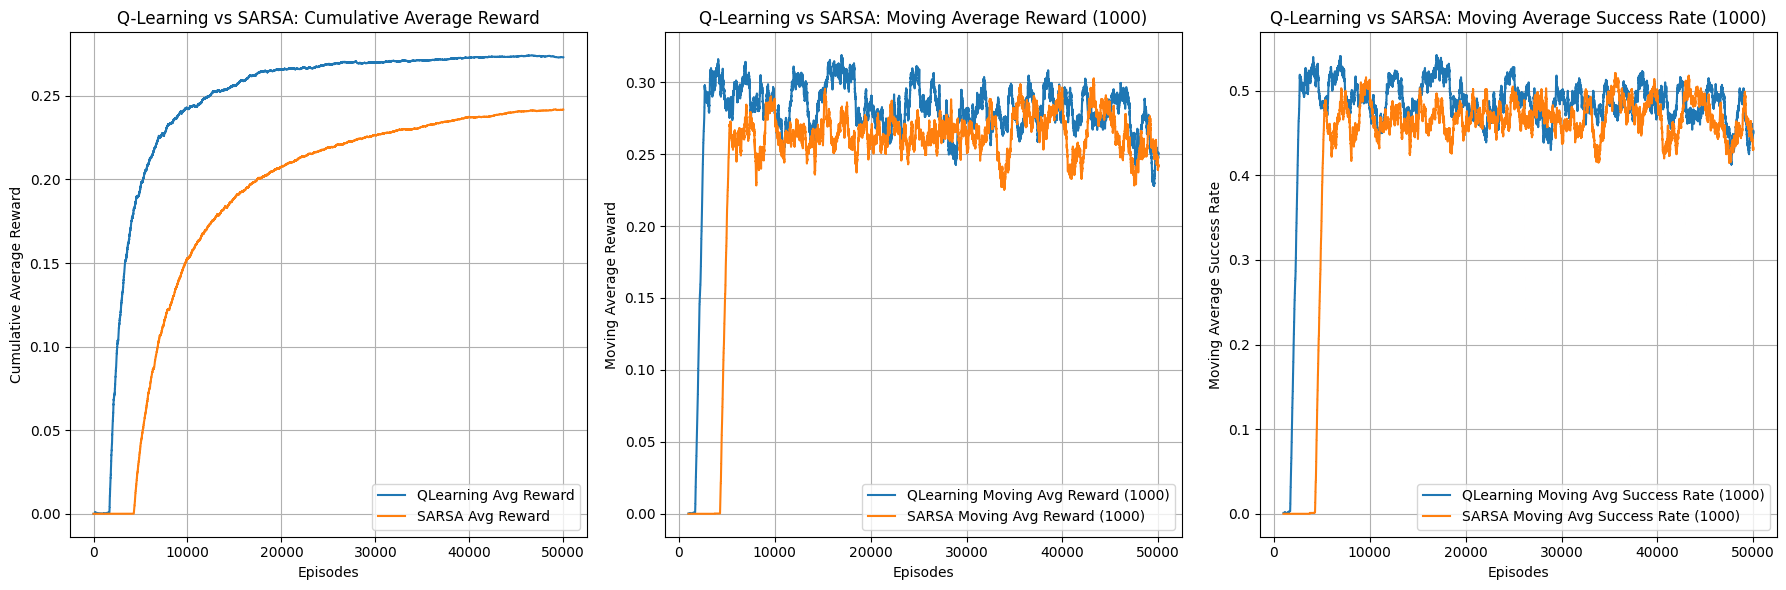

In [19]:
# --- 결과 시각화 및 분석 (과제 1) ---
plt.figure(figsize=(18, 6))

# 1. 누적 평균 보상 비교
plt.subplot(1, 3, 1)
plt.plot(pd.Series(rewards_q).cumsum() / (pd.Series(np.arange(len(rewards_q))) + 1), label="QLearning Avg Reward")
plt.plot(pd.Series(rewards_sarsa).cumsum() / (pd.Series(np.arange(len(rewards_sarsa))) + 1), label="SARSA Avg Reward")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Average Reward")
plt.title("Q-Learning vs SARSA: Cumulative Average Reward")
plt.legend()
plt.grid(True)

# 2. 이동 평균 보상 비교 (더 부드러운 추세 확인)
window_size = 1000 # 이동 평균 윈도우 크기
plt.subplot(1, 3, 2)
plt.plot(pd.Series(rewards_q).rolling(window_size).mean(), label=f"QLearning Moving Avg Reward ({window_size})")
plt.plot(pd.Series(rewards_sarsa).rolling(window_size).mean(), label=f"SARSA Moving Avg Reward ({window_size})")
plt.xlabel("Episodes")
plt.ylabel("Moving Average Reward")
plt.title(f"Q-Learning vs SARSA: Moving Average Reward ({window_size})")
plt.legend()
plt.grid(True)

# 3. 이동 평균 성공률 비교
plt.subplot(1, 3, 3)
plt.plot(pd.Series(success_q).rolling(window_size).mean(), label=f"QLearning Moving Avg Success Rate ({window_size})")
plt.plot(pd.Series(success_sarsa).rolling(window_size).mean(), label=f"SARSA Moving Avg Success Rate ({window_size})")
plt.xlabel("Episodes")
plt.ylabel("Moving Average Success Rate")
plt.title(f"Q-Learning vs SARSA: Moving Average Success Rate ({window_size})")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Q-테이블 시각화 (Heatmap 예시 - 상태 표현이 그리드 인덱스일 때 가능)
def plot_q_table_heatmap(q_table, title, grid_width, grid_height):
    max_q_grid = np.full((grid_height, grid_width), -np.inf) # 최소값으로 초기화
    policy_grid = np.full((grid_height, grid_width), -1, dtype=int) # 정책 저장 (-1: 정보 없음)
    action_symbols = {0: '←', 1: '→', 2: '↑', 3:' P', 4:' D', 5:' T', 6:' D'} # 행동 심볼 예시 (MiniGrid 따라 수정)

    valid_states = 0
    for state, q_values in q_table.items():
        # state가 위치 인덱스(정수)라고 가정
        if isinstance(state, int) and 0 <= state < grid_width * grid_height:
            row = state // grid_width
            col = state % grid_width
            max_q = max(q_values)
            best_action = np.argmax(q_values) # 최대 Q값 행동
            max_q_grid[row, col] = max_q
            policy_grid[row, col] = best_action
            valid_states += 1
        # else: # 상태가 튜플 등 다른 형태면 처리 불가
            # print(f"Skipping non-integer state for heatmap: {state}")

    if valid_states == 0:
        print(f"{title}: 히트맵 생성 불가 (유효한 정수 상태 없음)")
        return

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    im = plt.imshow(max_q_grid, cmap='viridis', interpolation='nearest')
    plt.colorbar(im, label='Max Q-value')
    plt.title(f'{title} - Max Q-value Heatmap')
    plt.xticks(np.arange(grid_width))
    plt.yticks(np.arange(grid_height))

    # 정책 히트맵 (각 셀에 최적 행동 표시)
    plt.subplot(1, 2, 2)
    im = plt.imshow(policy_grid, cmap='Pastel2', interpolation='nearest', vmin=-1, vmax=num_actions)
    # plt.colorbar(im, label='Best Action Index')
    plt.title(f'{title} - Policy Heatmap')
    plt.xticks(np.arange(grid_width))
    plt.yticks(np.arange(grid_height))
    # 각 셀에 행동 심볼 표시
    for r in range(grid_height):
        for c in range(grid_width):
            action_idx = policy_grid[r, c]
            if action_idx != -1:
                plt.text(c, r, action_symbols.get(action_idx, str(action_idx)),
                         ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

# DoorKey 환경 크기에 맞게 설정 (예: 5x5)
# grid_w, grid_h = 5, 5
# _convert_state 함수가 상태를 어떻게 반환하는지에 따라 plot_q_table_heatmap 함수 수정 필요
# 만약 _convert_state가 단순 위치 인덱스를 반환한다면 아래 코드가 동작할 수 있음
# plot_q_table_heatmap(q_table_q, "QLearning", grid_w, grid_h)
# plot_q_table_heatmap(q_table_sarsa, "SARSA", grid_w, grid_h)
# 상태 표현이 복잡하면 (튜플 등) 히트맵 생성 어려움

In [16]:
# plt.figure(figsize=(16, 8))
# plt.plot(q_logs.cumsum() / (pd.Series(np.arange(q_logs.shape[0]))+1), label="QLearning")
# # plt.plot(sarsa_logs.cumsum() / (pd.Series(np.arange(sarsa_logs.shape[0]))+1), label="SARSA")
# plt.legend()


--- 과제 3: Discount Factor (γ) 변화 실험 (QLearning 사용) ---

Gamma = 0.1 로 QLearning 학습 시작...

QLearning 학습 시작...
Episode: 1000/50000, Avg Reward (Last 100): 0.000, Avg Success Rate (Last 100): 0.000
Episode: 2000/50000, Avg Reward (Last 100): 0.320, Avg Success Rate (Last 100): 0.560
Episode: 3000/50000, Avg Reward (Last 100): 0.273, Avg Success Rate (Last 100): 0.500
Episode: 4000/50000, Avg Reward (Last 100): 0.318, Avg Success Rate (Last 100): 0.570
Episode: 5000/50000, Avg Reward (Last 100): 0.318, Avg Success Rate (Last 100): 0.550
Episode: 6000/50000, Avg Reward (Last 100): 0.284, Avg Success Rate (Last 100): 0.490
Episode: 7000/50000, Avg Reward (Last 100): 0.244, Avg Success Rate (Last 100): 0.390
Episode: 8000/50000, Avg Reward (Last 100): 0.287, Avg Success Rate (Last 100): 0.500
Episode: 9000/50000, Avg Reward (Last 100): 0.327, Avg Success Rate (Last 100): 0.630
Episode: 10000/50000, Avg Reward (Last 100): 0.261, Avg Success Rate (Last 100): 0.470
Episode: 11000/50000, Avg Rew

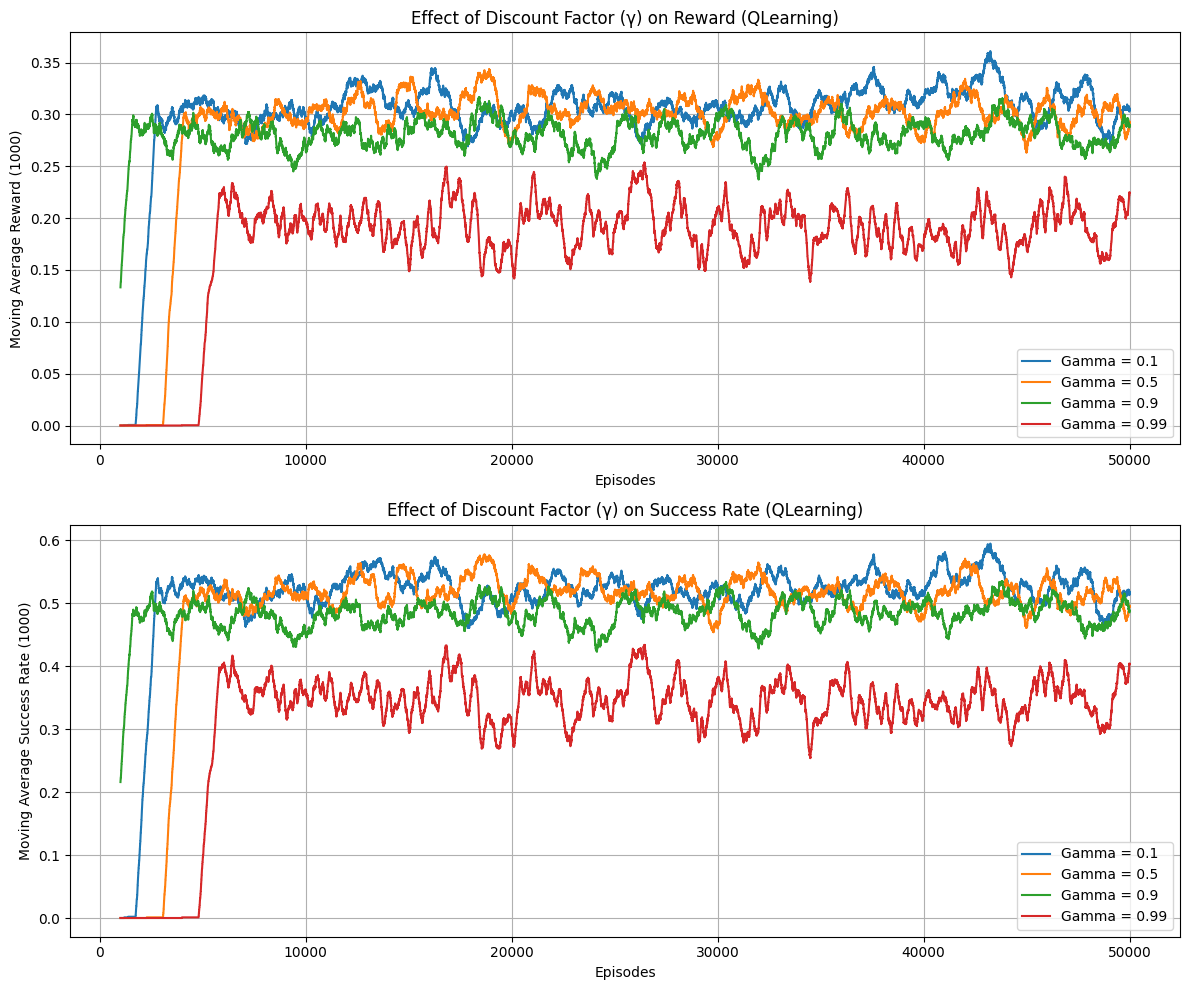


모든 실험 완료.


In [20]:
# --- 과제 3: Discount Factor (γ) 변화 실험 ---
print("\n--- 과제 3: Discount Factor (γ) 변화 실험 (QLearning 사용) ---")

gamma_values = [0.1, 0.5, 0.9, 0.99]
results_gamma = {}

for gamma_val in gamma_values:
    print(f"\nGamma = {gamma_val} 로 QLearning 학습 시작...")
    # 새 에이전트 인스턴스 생성
    q_agent_gamma = QLearning(actions=num_actions, gamma=gamma_val)
    # 학습 실행
    rewards_gamma, success_gamma, _ = train(q_agent_gamma, env, num_episodes, max_steps_per_episode, 'QLearning')
    results_gamma[gamma_val] = {'rewards': rewards_gamma, 'success': success_gamma}
    # 결과 저장
    pd.Series(rewards_gamma).to_csv(f'./logs/rewards_qlearning_gamma{gamma_val}_{env_name}.csv')
    pd.Series(success_gamma).to_csv(f'./logs/success_qlearning_gamma{gamma_val}_{env_name}.csv')
    print(f"Gamma = {gamma_val} 학습 결과 저장 완료.")

# --- 결과 시각화 및 분석 (과제 3) ---
plt.figure(figsize=(12, 10))

# 1. 감마값별 이동 평균 보상 비교
plt.subplot(2, 1, 1)
for gamma_val, result in results_gamma.items():
    plt.plot(pd.Series(result['rewards']).rolling(window_size).mean(), label=f'Gamma = {gamma_val}')
plt.xlabel("Episodes")
plt.ylabel(f"Moving Average Reward ({window_size})")
plt.title("Effect of Discount Factor (γ) on Reward (QLearning)")
plt.legend()
plt.grid(True)

# 2. 감마값별 이동 평균 성공률 비교
plt.subplot(2, 1, 2)
for gamma_val, result in results_gamma.items():
    plt.plot(pd.Series(result['success']).rolling(window_size).mean(), label=f'Gamma = {gamma_val}')
plt.xlabel("Episodes")
plt.ylabel(f"Moving Average Success Rate ({window_size})")
plt.title("Effect of Discount Factor (γ) on Success Rate (QLearning)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n모든 실험 완료.")

# 비디오 생성 및 재생 (선택적)
# 학습된 에이전트로 환경 실행 및 비디오 저장
# env_record = gym.wrappers.Monitor(gen_wrapped_env(env_name), './videos', force=True)
# state = q_agent._convert_state(env_record.reset())
# done = False
# while not done:
#     action = q_agent.act(state) # 학습된 정책 사용 (epsilon=0 설정 필요)
#     obs, reward, done, info = env_record.step(action)
#     state = q_agent._convert_state(obs)
# env_record.close()
# show_video()